# Seasonal Regression for Portland General Electric's Demand

This notebook aims to employ simple methods to forecast day-ahead demand for Portland General Electric, while
accounting for the weather at Portland International Airport. 
I'll play with a couple exponential smoothing methods, while accounting for the seasonal patterns. 

The electricity demand series shows daily, weekly, and annual oscillations.  At a short time scale, I aim to capture the first two of these.
I'l assume that any decent updating algorithm should follow the annual oscillations. 

The approaches I've seen suggest Fourier Series (harmonic regression), linear regression, and Seasonal ARIMA.
I've settled on using a seaonal Holt-Winters smoothing, since it's a simple method with a clear way of handling the seasonality.
It is also fairly intuitive, there is a base rate, with some daily pattern superimposed.  I'll extend this to also include the
non-linear temperature model. 
It may be possible to also use a multiple seasonal ARIMA approach, by considering yesterday's and last weeks generation.  

This notebook is an attempt to build a simple, model including the daily and weekly seasonality, along with temperature data.
As the explorations in "EBA_explore" found, demand varies most strongly with the deviation of the temperature from some optimum:
basically people like it to be around $15-20$ degrees Celcius, and will cool or heat their environment to keep that.


What are the existing methods for doing this?
There must be some reviews on this, as well as readily applicable techniques. 
* ARMA - need to remove obvious daily/weekly seasonality? I really need an ARMAX model, to include temperature.
 ARMA models require stationarity, and I'm currently tying myself up in knots trying to remove the daily oscillations.
 One approach is to just consider one hour at a time? 

* Gradient Boosted Regression Trees (Winning technique at GEFCOM 2014 forecasting competition)
* Recurrent Neural Network - train a neural network.  Feed it time-of-day, temperature, weekend/holiday.  (I have a small play network going.)

I'll train the models on the 2016 data, and validate on the 2017 data.
I'll use the RMSE or MSE as a metric for success.

I'll use a persistance forecast as my baseline, so tomorrow's demand is the same as today's. 

## Multiple Seasonal Exponential Smoothing

This follows Rob Hyndman's approach towards multi-seasonal exponential smoothing (https://robjhyndman.com/papers/multiseasonal.pdf).
This approach generalizes Holt-Winters smoothing to multiple seasons.
Hyndman's analysis includes forecasts of electricity generation, based on utility data (from well over 10 years ago).
I believe an improved version was used in a later paper which also included Fourier series to handle electrical demand in Turkey. 

I chose to follow this model since most attempts at ARIMA rely on removing the seasonality, and I had hoped to just follow best practice with existing libraries.
Initial naive methods yield poor results, and failed to remove the seasonal pattern, or even worse imposed one.
An initial attempt at Fourier filtering on over a year of data also left similar trends.
Perhaps the Fourier approach could be salvaged via more sensible windowing functions. 

The simple model for a variable $y_{t}$, with seasonal pattern with period $m$ is
\begin{align}
  y_{t} &= l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_{t} \\
  l_{t} &= l_{t-1} + \alpha\epsilon_{t} \\
  b_{t} &= b_{t-1} + \beta \epsilon_{t} \\
  s_{t} &= s_{t-m} + \gamma \epsilon_{t}
\end{align}
where $l_{t}, b_{t}, s_{t}$ are the level, trend and seasonal patterns respectively.
The noise/innovation $\epsilon_{t}$ is assumed to be i.i.d. Gaussian and obey
$E[\epsilon_{t}]=0, E[\epsilon_{t}\epsilon_{s}]=\delta_{ts}\sigma^2$.
The innovation is estimated as the difference between the actual result and the predicted result, $\epsilon_t=\hat{y}_t-y_t$.
The constants $\alpha,\beta,\gamma$ are between zero and one, and determined by fitting to past data.
(Hyndman notes that $m+2$ estimates must be made for the initial values of the level, trend and seasonal pattern).

Hyndman's model allows multiple seasons, and allows the sub-seasonal terms to be updated more quickly than once per large season.  In utility data, the short season is the daily oscillation, while the longer season comes from the weekly oscillation induced by the work week.  For hourly data, the daily cycle has length $m_{1}=24$, with the weekly cycle taking $m_{2}=168$.  The ratio between them is $k=m_{2}/m_{1}=7.$  The number of seasonal patterns is $r\le k$.


(I'm going to change Hyndman's notation to use $\mathbf{I}$ to denote indicator/step functions).
\begin{align}
  y_{t} &= l_{t-1}+b_{t-1} +\sum_{i=1}^{r} \mathbf{I}_{t,i}s_{i,t-m_1} +\epsilon_{t}\\
  l_{t} &= l_{t-1} + b_{t-1}+\alpha\epsilon_{t}\\
  b_{t} &= b_{t-1} + \beta\epsilon_{t}\\
  s_{i,t} &= s_{i,t-m_1} + \sum_{j=1}^{r}\left(\gamma_{ij}\mathbf{I}_{t,j}\right) \epsilon_{t}  (i=1,2,\ldots,r) \\
\end{align}
Here the indicator functions $\mathbf{I}_{t,i}$ are unity if $t$ is in the seasonal pattern $i$, and zero otherwise.  For utility data, this will probably be weekday and holiday/weekend.  Here $\gamma_{ij}$ denotes how much one seasonal pattern is updated based on another---Hyndman proposes a number of restrictions on these parameters.

I will extend this to include an external variables for the deviation above a given temperature, so that $y_{t}\rightarrow y_{t}+\tau_p\Theta(T_t-T_p)+\tau_{n}\Theta(T_n-T_t)$.
This model allows different coefficients for energy use as a function of heating and cooling, as well as a flat region.
I will put restrictions on $T_{p}$, $T_{n}$, so that these are in reasonable ranges, $T_{p}>10,T_{n}$, $T_n<

He suggests using the first four weeks of data to estimate the parameters, by minimizing the squared error of the one-step ahead forecast.  Apparently maximum likelihood estimation was not recommended (10 years ago).

So how to fit the parameters?  A really simple approach would be gradient descent?  Intuitively, the level is the average value, the bias is the average gradient.  The seasonality is the average seasonal pattern.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from util.get_weather_data import convert_isd_to_df, convert_state_isd
from util.EBA_util import remove_na, avg_extremes

from numpy import pi,e

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
try:
    #load in preprepared joint dataset.  
    df_joint=pd.read_csv('data/pdx_joint.txt',
        index_col=0, parse_dates=True)
    print('Read in PDX Frame from file')
    dem=df_joint['Demand'].copy()
    temp=df_joint['Temp'].copy()
    fore=df_joint['Forecast'].copy()
except:
    air_df = pd.read_csv('data/air_code_df.gz')
    #Just get the weather station data for cities in Oregon.
    df_weather=convert_state_isd(air_df,'OR')
    #Select temperature for Portland, OR
    msk1=np.array(df_weather['city']=='Portland')
    msk2=np.array(df_weather['state']=='OR')
    df_pdx_weath=df_weather.loc[msk1&msk2]
    #get electricity data for Portland General Electric
    df_eba=pd.read_csv('data/EBA_time.gz',index_col=0,parse_dates=True)
    msk=df_eba.columns.str.contains('Portland')
    df_pdx=df_eba.loc[:,msk]
    msk1=  df_pdx.columns.str.contains('[Dd]emand') 
    dem=df_pdx.loc[:,msk1]
    #Make a combined Portland Dataframe for demand vs weather.
    df_joint=pd.DataFrame(dem)
    df_joint=df_joint.join(df_pdx_weath)
    temp=df_joint['Temp']
    df_joint['TempShift']=150+abs(temp-150)
    df_joint = df_joint.rename(columns={df_joint.columns[0]:'Demand',
             df_joint.columns[1]:'Forecast'})
    df_joint.to_csv('data/pdx_joint.txt')


Read in PDX Frame from file


In [3]:
#clea data: remove NA values by replacing with median.  Then average down 4sigma excursions by their nearest neighbours.
dem = remove_na(dem,window=24)
dem = avg_extremes(dem)
temp = avg_extremes(remove_na(temp))

Number of extreme values 0. Number of zero values 148
Number of NA values 56
Number of extreme values 1. Number of zero values 3
Number of NA values 156


I am currently replacing NA values with the average of the neighbouring days.  This manages to handle the occasional missing day, which is surprisingly common.   

## Optimizing Hyperparameters

The following code tries to optimize the hyperparameters.  It seems to lock onto essentially a persistence model.  The best guess is to just use yesterday's electricity usage to predict today's. Considering that was going to be my benchmark for simple and effective, this is somewhat disheartening.

I tried this numerically rather than via directly coding up gradient descent, since the closed form derivatives become nasty polynomials in the parameters $(\alpha,\beta,\gamma)$. The previous values $ y_{t-1} $ also depend on the choice of parameters, so when you consider the derivative of the cost function
$\partial_\alpha J = T^{-1}\sum_t \epsilon_{t}\partial_\alpha\epsilon_{t}$ there is a nested sum of terms (since the parameter estimates rely on the previous errors too).

In [92]:
from EBA_seasonal.multiseasonal import multiseasonal as ms

In [98]:
shift=7
start = 24*7*40+shift
end =  start+24*7*4+24*7*6
#Grab subset, and adjust to timezone.
dem_sub = dem[start:end].tz_localize('utc').tz_convert('US/Pacific')
temp_sub = temp[start:end].tz_localize('utc').tz_convert('US/Pacific')
fore_sub = fore[start:end].tz_localize('utc').tz_convert('US/Pacific')

alpha2=0.1
beta2=0.1
gamma2=np.array([[0.1,0.02],[0.02,0.1]])
ms_model2=ms(alpha=alpha2,beta=beta2,gamma=gamma2)
=-ypred=ms_model2.optimize_param(dem_sub,rtol=1E-4,nmax=100)

_alpha 0.99
_beta 0.999195020887
_g00 0.995069964138
_g01 0.862099925058
_g10 0.662400428419
_g11 0.619824581122
Failed to hit tolerance after 100 iter

Cost: 168.53404623 168.53404623


Cost, Old Cost = 168.53404623004775,168.2474619659095


So while this hasn't completely converged, the trend is plain enough: this model wants a persistence model, where tomorrow's demand is the same as today's demand.

I suspect, this is because this model has no access to weather data, which is clearly a strong driver. 

Note: Naively the fitting routine expects each segment of 24 entries to run over one day.  Violating this assumption leads to exponentially growing errors.

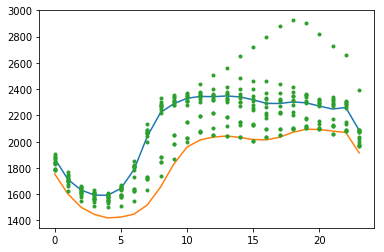

In [288]:
plt.plot(est.T)
plt.plot(dem_sub[-2*168:].index.hour,dem_sub[-2*168:].values,'.')
plt.show()

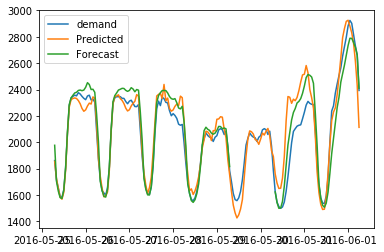

In [289]:
plt.plot(dem_sub[-168:],label='demand')
plt.plot(ypred[-168:],label='Predicted')
plt.plot(fore_sub[-168:],label='Forecast')
plt.legend()
plt.show()

Let's now look at our errors. From eyeballing the last week it's clear
that my method is pretty weak, and underperforms relative to the actual PGE forecast.

6727

In [143]:
mape = lambda x,y: np.mean(np.abs(1-(x)/(y+1E-16)))

In [142]:
mape(np.array([1.0,2.0]),np.array([2.0,4.0]))

0.5

In [144]:
#Only compare results after initial lock-in period.
#So drop first 4 weeks
skip=4*168
pred_rmse=ms_model2.rmse(ypred[skip:],dem_sub[skip:])
fore_rmse=ms_model2.rmse(fore_sub[skip:],dem_sub[skip:])

print('My predicted error: {}'.format(pred_rmse))
print('Actual forecast error: {}'.format(fore_rmse))

My predicted error: 168.53404623004775
Actual forecast error: 72.4106044369237


array([ 1957.,  1805.,  1728., ...,  2330.,  2350.,  2217.])

In [146]:
pers_mape = mape(dem_sub[(skip-24):-24].values, dem_sub[skip:].values)
pred_mape = mape(ypred[skip:], dem_sub[skip:])
fore_mape = mape(fore_sub[skip:], dem_sub[skip:])

print('Persistence percentage error: {}'.format(pers_mape))
print('My predicted percentage error: {}'.format(pred_mape))
print('Actual forecast percentage error: {}'.format(fore_mape))

Persistence percentage error: 0.05323434359150992
My predicted percentage error: 0.04841695438230639
Actual forecast percentage error: 0.02462616675367612


So this model's error is twice the actual forecast error.

So possible reasons:
- I have only a single series, and a few years of data.

I only have access to this one time series, rather than
the more detailed info PGE would have to possible segment the total
demand.

Second, this only has prior demand, rather than current temperature
or forecasts.  We know that's a big driver. PGE will have their
own weather forecast to use in these models.

Third, this is a super simple model.  Unfortunately, it's
barely better than persistence, which is unfortunate. 

I can at least fix the second of those, by incorporating past weather
forecast data.

## Multiple Seasonality and Temperature

Let's now try to also include the temperature.  From earlier graphs, we'll try to fit a model of the form $A_0|T-T_0|$, i.e. electricity usage linearly increases the further the temperature is from some ideal temperature.  Let's try to first fit the temperature component, then
fit the remainder with the prior exponential smoothing model.

I'll assume that heating/cooling might have different coefficients, so the temperature component of the model at time $t$ is
\begin{equation}
D_{t} =  a_{0}+ a_{+}[T_{t}-T_{+}]_{+} + a_{-}[T_{-}-T_{t}]_{+},
\end{equation}
where $[f]_{+}=f$ if $f>0$, and is zero otherwise.

In lieu of having actual forecast data, I'm doing to use the actual recorded temperatures to develop the backcast. I should be able to beat the genuine day-ahead forecast, since those are relying on the weather forecast which has its own errors.  But I'm handicapped by only having a limited subset of data (the aggregate demand for a given company)
to forecast on, and guessing about which stations are important. 


In [254]:
from EBA_seasonal.multiseasonal_temp import multiseasonal_temp as ms_temp

In [261]:
shift=7
start = 24*7*24+shift
end =  start+24*7*4+24*7*20
#Grab subset, and adjust to timezone.
dem_sub = dem[start:end].tz_localize('utc').tz_convert('US/Pacific')
temp_sub = temp[start:end].tz_localize('utc').tz_convert('US/Pacific')
fore_sub = fore[start:end].tz_localize('utc').tz_convert('US/Pacific')

alpha2=0.3
beta2=0.2
gamma2=0.05*np.array([[1,0.8],[0.8,1]])
ms_model3=ms_temp(alpha=alpha2,beta=beta2,gamma=gamma2,
Ap=6,An=5,Tp=200,Tn=150)


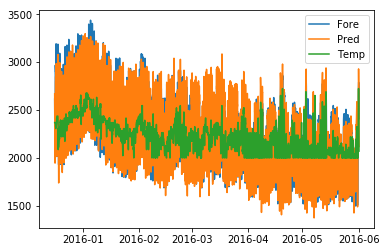

In [290]:
#Plot initial predictions, and temperature model.
ytot3=ms_model3.STL_dayahead(dem_sub,temp_sub)
temp_model=ms_model3.Tmodel(temp_sub)
ms_model3.plot_pred([fore_sub,ytot3,2000+temp_model],['Fore','Pred','Temp'])

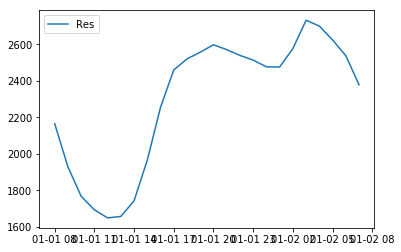

In [291]:
ms_model3.plot_pred([ytot3['2016-01-01']-temp_model['2016-01-01']],['Res'])

In [264]:
debug=False
ypred=ms_model3.optimize_param(dem_sub,temp_sub,rtol=1E-2,nmax=100,lr=0.01)

Iter 100.  Cost 100.38151012168807
Failed to hit tolerance after 100 iter

Cost: 100.381510122 100.381510122


Cost, Old Cost = 100.38151012168807,100.39020529122762


In [265]:
#Current best bet on parameters
ms_model3.opt_param

{'An': 3.9267997323239148,
 'Ap': 6.5272227269487715,
 'Tn': 150.08626320520531,
 'Tp': 200.1228669469873,
 'alpha': 0.16120776194559208,
 'beta': 0.19301566190153127,
 'g00': 0.059020723246723576,
 'g01': 0.049197194546316055,
 'g10': 0.0054450652090559199,
 'g11': 0.11453486221668183}

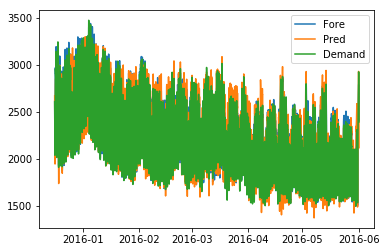

In [292]:
pred=ms_model3.STL_dayahead(dem_sub,temp_sub)
ms_model3.plot_pred([fore_sub,pred,dem_sub],['Fore','Pred','Demand'])

In [267]:
pers_mape = mape(dem_sub[(skip-24):-24].values, dem_sub[skip:].values)
pred_mape = mape(ypred[skip:], dem_sub[skip:])
fore_mape = mape(fore_sub[skip:], dem_sub[skip:])

print('Persistence percentage error: {}'.format(pers_mape))
print('My predicted percentage error: {}'.format(pred_mape))
print('Actual forecast percentage error: {}'.format(fore_mape))

Persistence percentage error: 0.0477042384837031
My predicted percentage error: 0.03407852025552736
Actual forecast percentage error: 0.024113200544899443


Trying to start training 10 weeks in (Nov 2015) gets crazy answers.
So, for small time periods this seems to work, but I seem to have engineered an unstable algorithm.

Some periods are worse.  It seems April 2016 is well behaved, but around the winter holidays yields crazy answers, perhaps due to missing those holidays, and causing the errors to propagate through the rest of the system?

This makes the neural network more attractive: throw all of the information at it, and let the algorithm extract the useful correlations
from the data. Of course, you have a hard time explaining exactly what the network found.

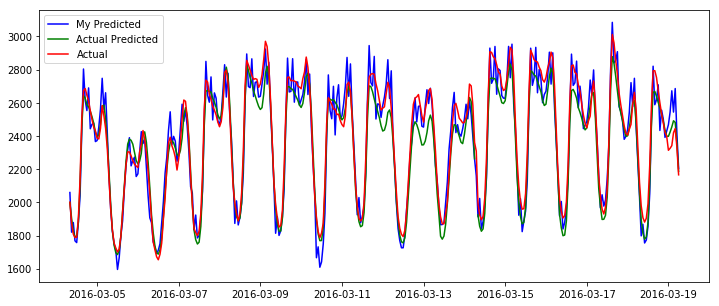

In [293]:
per=slice('2016-03-04','2016-03-18')
plt.figure(figsize=(12,5))
plt.plot(ytot3[per],'b',label='My Predicted')
plt.plot(fore_sub[per],'g',label='Actual Predicted')
plt.plot(dem_sub[per],'r',label='Actual')
plt.legend()
plt.show()

# Testing the model

So after fitting a model, let's try running on the full dataset.



In [274]:
#Now run on the whole thing
test_end=-1
dem_test = dem[start:test_end].tz_localize( 'utc').tz_convert('US/Pacific')
temp_test = temp[start:test_end].tz_localize( 'utc').tz_convert('US/Pacific')
fore_test = fore[start:test_end].tz_localize( 'utc').tz_convert('US/Pacific')

#now run the whole thing from start to end.
ytot3=ms_model3.STL_dayahead(dem_test,temp_test)

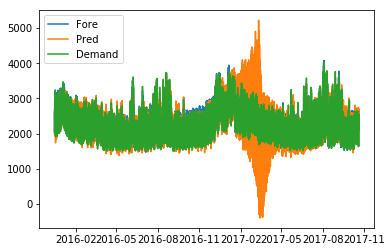

In [294]:
pred_test=ms_model3.STL_dayahead(dem_test,temp_test)
ms_model3.plot_pred([fore_test,pred_test,dem_test],['Fore','Pred','Demand'])

Ouch.  So the model was trained on data up to December 2016.
Shortly after that period, the model stops tracking the correct results,
leading to growing oscillations.  These are eventually damped out, but this is awful performance. 

In [284]:
ms_model3.opt_param

{'An': 3.9267997323239148,
 'Ap': 6.5272227269487715,
 'Tn': 150.08626320520531,
 'Tp': 200.1228669469873,
 'alpha': 0.16120776194559208,
 'beta': 0.19301566190153127,
 'g00': 0.059020723246723576,
 'g01': 0.049197194546316055,
 'g10': 0.0054450652090559199,
 'g11': 0.11453486221668183}

Let's look more closely at that problem period.  

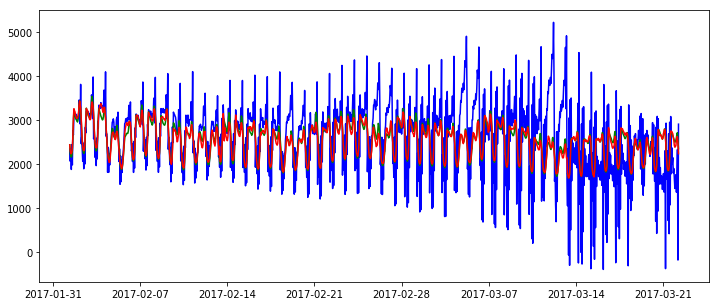

In [296]:
per=slice('2017-02-01','2017-03-21')
plt.figure(figsize=(12,5))
plt.plot(pred_test[per],'b',label='My Predicted')
plt.plot(fore_test[per],'g',label='Actual Predicted')
plt.plot(dem_test[per],'r',label='Actual')
plt.show()

It looks like I have some errors leading to growing over-corrections.
What do I think is going on?

- Inconsistent model fitting/generation?  I almost certainly have lingering issues in this model, that may be fitting something inconsistently.  
- The model assumes a fixed temperature variation over the year. Maybe energy usage does vary, and this simple model is leading to incorrect results?  If those errors get large enough then they could oscillate? 
- There is definitely a problem with discontinuities (such as from inference and missing values or daylight savings). This also showed up whn the 24 hour cycle is not in sync.  

## Extensions and Fixes

So, how would this scale to more ISOs?  With trade between them?
Right now this barely fits a single linear model.  But, I think an extension to more tensor indices for locations would do the job.  The update parameters would have to become matrices too.

Another fix is to treat each day with its own seasonal pattern.  That will definitely require a better version of the gradient calculation.

But, I'm not going to do that.  This is currently punishing to run since it is heavily unoptimized in slow python code rather than numpy,
and it used a finite-difference for the optimization.  So it requires $(N_P+1)$ runs.  It looks like using numba and jit won't really work, as is, since numba does not play nice with objects/classes.  